In [1]:
# import necessary library
import pandas as pd
import re
from collections import Counter
import nltk
from debugpy.launcher.debuggee import process
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import seaborn as sns
from sklearn.manifold import MDS
from nltk.stem import PorterStemmer
from tabulate import tabulate
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [2]:
# Load the dataset
data = pd.read_csv('tinder_google_play_reviews.csv')

# Data preprocessing
# Convert the 'at' column to datetime
data['at'] = pd.to_datetime(data['at'], errors='coerce')

# Drop rows with missing values in the necessary columns
data = data.dropna(subset=['content', 'reviewCreatedVersion', 'score', 'thumbsUpCount', 'at'])

# Filter rows with 'at' after January 1, 2024
data = data[data['at'] > '2024-01-01']

# Select the relevant columns
data = data[['content', 'score', 'thumbsUpCount', 'at']]

# Extract the text content
text = data['content']

# Check the filtered data
print(data.head())


                                             content  score  thumbsUpCount  \
0  This app is 100% a money scam and I didn't eve...      1              1   
2  Straightforward, safety features and super eas...      5              0   
3               I got banned over a meme. Hella lame      1              0   
4  Mandatory facial check.👎🏼 I do not want to giv...      1              1   
6                                          excellent      5              0   

                   at  
0 2025-02-14 00:30:37  
2 2025-02-13 23:26:33  
3 2025-02-13 23:15:32  
4 2025-02-13 23:01:52  
6 2025-02-13 22:13:29  


# Text preprocessing: tokenization, lemmatization and POS tagging

In [3]:
# POS tagging + lemmatization for a categorized perception of the comment
pos_tags = []

for text in text:
    text.lower()
    tokens = word_tokenize(text)  # Tokenize the sentence
    tags = pos_tag(tokens)  # Apply POS tagging
    pos_tags.append(tags)  # Append the tags to the list

dic_noun = []
dic_adj = []
dic_verbs = []

# Flatten the list of POS tags
flattened_pos_tags = [tag for sublist in pos_tags for tag in sublist]
pos_tags = flattened_pos_tags


# Function to map POS tags to WordNet format
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

# Initialize lemmatizer and dictionaries
lemmatizer = WordNetLemmatizer()

# Lemmatization and classification
for token, tag in pos_tags:
    lemmatized_word = lemmatizer.lemmatize(token, get_wordnet_pos(tag))

    if tag.startswith('J'):
        dic_adj.append(lemmatized_word)
    elif tag.startswith('N'):
        dic_noun.append(lemmatized_word)
    elif tag.startswith('V'):
        dic_verbs.append(lemmatized_word)

          Word  Frequency
0         good       4621
1         fake       1911
2         nice       1842
3          bad       1524
4         many       1482
5         same       1129
6         more       1068
7          new        995
8         free        974
9        other        946
10       great        895
11        real        754
12        best        688
13        Good        655
14         few        645
15        much        623
16         app        553
17   expensive        547
18      single        525
19        able        476
20           i        475
21        full        452
22     useless        426
23       wrong        361
24       first        354
25           u        340
26        most        315
27        only        300
28     premium        285
29        sure        281
30       super        271
31        easy        267
32        last        266
33    terrible        258
34       least        257
35   different        241
36  ridiculous        237
37         o

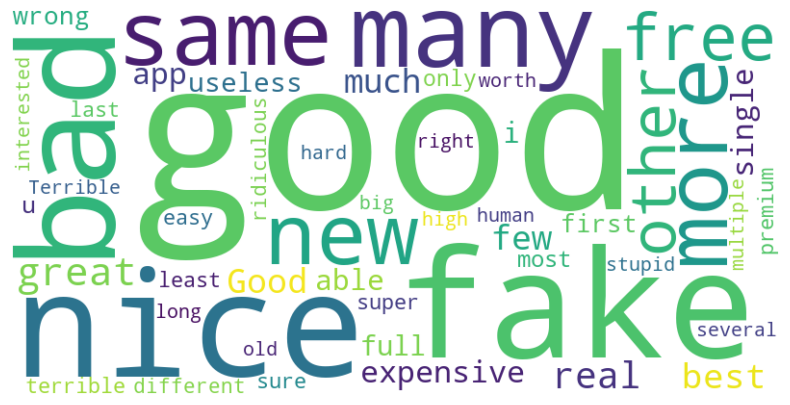

In [43]:
# Count the frequency of each adj
word_counts_adj = Counter(dic_adj)

# Get the top 50 most common adj
top_50_adj  = word_counts_adj.most_common(50)

# Convert to DataFrame and call it top_50_df
top_50_adj_df  = pd.DataFrame(top_50_adj, columns=['Word', 'Frequency'])
# Create a dictionary of words and their frequencies for the word cloud
print(top_50_adj_df)

word_freq_dict = dict(top_50_adj)
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for the word cloud
plt.show()

# Lexicon-Based Sentiment Analysis

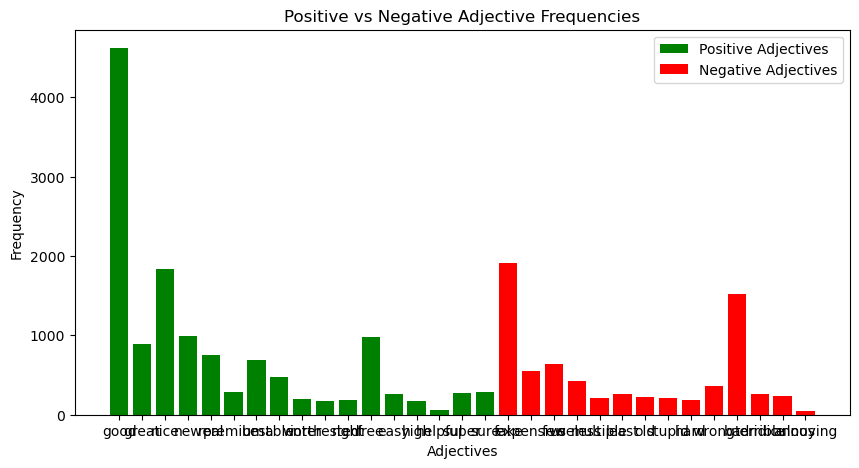

In [45]:
# Classify positive and negative adjectives
positive_words = [
    'good', 'nice', 'great', 'free', 'best', 'new', 'real', 'able', 'super', 
    'premium', 'sure', 'easy', 'helpful', 'interested', 'high', 'worth', 'right'
]

negative_words = [
    'bad', 'fake', 'expensive', 'useless', 'terrible', 'stupid', 'ridiculous', 
    'wrong', 'hard', 'few', 'least', 'old', 'multiple', 'annoying'
]

# Count by category
positive_adj = {word: count for word, count in word_counts_adj.items() if word in positive_words}
negative_adj = {word: count for word, count in word_counts_adj.items() if word in negative_words}

# Visualize the results (bar chart)
plt.figure(figsize=(10, 5))
plt.bar(positive_adj.keys(), positive_adj.values(), color='green', label='Positive Adjectives')
plt.bar(negative_adj.keys(), negative_adj.values(), color='red', label='Negative Adjectives')
plt.xlabel("Adjectives")
plt.ylabel("Frequency")
plt.title("Positive vs Negative Adjective Frequencies")
plt.legend()
plt.show()

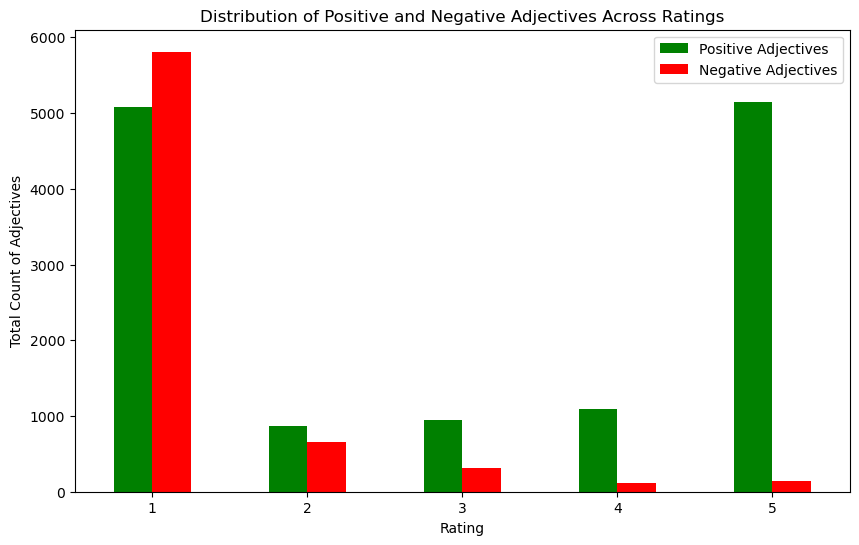

In [47]:
# Define dictionaries for positive and negative adjectives
positive_words = [
    'good', 'nice', 'great', 'free', 'best', 'new', 'real', 'able', 'super', 
    'premium', 'sure', 'easy', 'helpful', 'interested', 'high', 'worth', 'right'
]
negative_words = [
    'bad', 'fake', 'expensive', 'useless', 'terrible', 'stupid', 'ridiculous', 
    'wrong', 'hard', 'few', 'least', 'old', 'multiple', 'annoying'
]

# Extract adjectives from each review and classify them
def classify_adjectives(text):
    tokens = word_tokenize(text)  # Tokenize
    pos_tags = pos_tag(tokens)  # POS tagging
    adjectives = [
        lemmatizer.lemmatize(token, get_wordnet_pos(tag)) 
        for token, tag in pos_tags if tag.startswith('J')
    ]  # Extract adjectives and lemmatize them
    positive_count = sum(1 for word in adjectives if word in positive_words)  # Count positive words
    negative_count = sum(1 for word in adjectives if word in negative_words)  # Count negative words
    return positive_count, negative_count

# Apply to the dataset
data[['Positive_Count', 'Negative_Count']] = data['content'].apply(
    lambda x: pd.Series(classify_adjectives(x))
)

# Group by ratings and count total positive and negative adjectives
grouped = data.groupby('score')[['Positive_Count', 'Negative_Count']].sum()

# Visualize the results
grouped.plot(kind='bar', figsize=(10, 6), color=['green', 'red'])
plt.title('Distribution of Positive and Negative Adjectives Across Ratings')
plt.xlabel('Rating')
plt.ylabel('Total Count of Adjectives')
plt.xticks(rotation=0)
plt.legend(['Positive Adjectives', 'Negative Adjectives'])
plt.show()


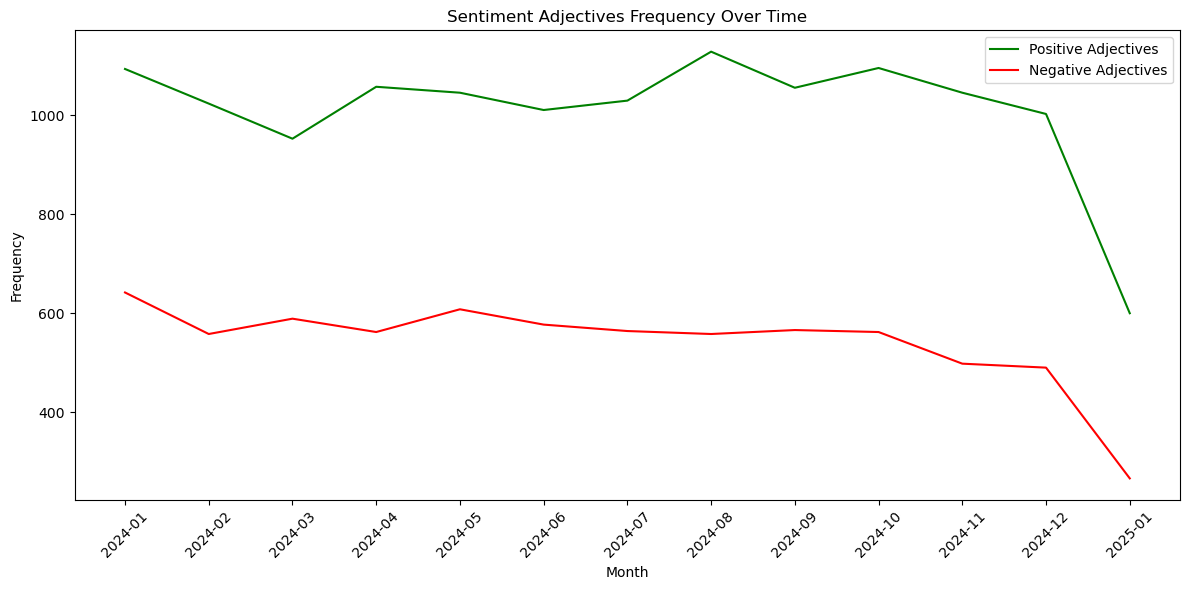

In [49]:
import matplotlib.pyplot as plt

# Step 1: Ensure the 'at' column is in datetime format
data['at'] = pd.to_datetime(data['at'], errors='coerce')

# Step 2: Extract the count of positive and negative adjectives for each review
def classify_adjectives(text):
    tokens = word_tokenize(text)  # Tokenize the text
    pos_tags = pos_tag(tokens)  # Perform POS tagging
    adjectives = [
        lemmatizer.lemmatize(token, get_wordnet_pos(tag)) 
        for token, tag in pos_tags if tag.startswith('J')
    ]  # Extract adjectives and lemmatize them
    positive_count = sum(1 for word in adjectives if word in positive_words)  # Count positive adjectives
    negative_count = sum(1 for word in adjectives if word in negative_words)  # Count negative adjectives
    return positive_count, negative_count

# Apply the function to the dataset
data[['Positive_Count', 'Negative_Count']] = data['content'].apply(
    lambda x: pd.Series(classify_adjectives(x))
)

# Group data by month and calculate the total frequency of positive and negative adjectives
data['year_month'] = data['at'].dt.to_period('M')  # Extract year and month
monthly_sentiment = data.groupby('year_month')[['Positive_Count', 'Negative_Count']].sum()

# Plot the trend of positive and negative adjective frequencies over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_sentiment.index.astype(str), monthly_sentiment['Positive_Count'], label='Positive Adjectives', color='green')
plt.plot(monthly_sentiment.index.astype(str), monthly_sentiment['Negative_Count'], label='Negative Adjectives', color='red')
plt.xticks(rotation=45)
plt.title('Sentiment Adjectives Frequency Over Time')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from collections import Counter

# Define the phrase extraction function
def extract_phrases(text):
    tokens = word_tokenize(text)  # Tokenize the text
    pos_tags = pos_tag(tokens)  # Perform POS tagging
    phrases = []

    for i, (word, tag) in enumerate(pos_tags):
        # Check for adjective + noun phrases
        if tag.startswith('J') and i + 1 < len(pos_tags) and pos_tags[i + 1][1].startswith('N'):
            adj = lemmatizer.lemmatize(word, wordnet.ADJ)
            noun = lemmatizer.lemmatize(pos_tags[i + 1][0], wordnet.NOUN)
            phrases.append(f"{adj} {noun}")
        
        # Check for adjective + verb phrases
        if tag.startswith('J') and i + 1 < len(pos_tags) and pos_tags[i + 1][1].startswith('V'):
            adj = lemmatizer.lemmatize(word, wordnet.ADJ)
            verb = lemmatizer.lemmatize(pos_tags[i + 1][0], wordnet.VERB)
            phrases.append(f"{adj} {verb}")
    
    return phrases

# Apply the phrase extraction function to each review
data['phrases'] = data['content'].apply(extract_phrases)

# Flatten all phrases into a single list
all_phrases = [phrase for phrases in data['phrases'] for phrase in phrases]

# Classify phrases as positive or negative
positive_phrases = [phrase for phrase in all_phrases if any(word in phrase.split() for word in positive_words)]
negative_phrases = [phrase for phrase in all_phrases if any(word in phrase.split() for word in negative_words)]

# Count the most frequent phrases
positive_phrases_counts = Counter(positive_phrases).most_common(30)  
negative_phrases_counts = Counter(negative_phrases).most_common(30)  

# Print the most frequent phrases
print("Top 30 Positive Phrases:")
print(positive_phrases_counts)

print("\nTop 30 Negative Phrases:")
print(negative_phrases_counts)


Top 30 Positive Phrases:
[('good app', 506), ('nice app', 415), ('great app', 211), ('super like', 149), ('real people', 143), ('best app', 129), ('new match', 116), ('good 👍', 107), ('new people', 102), ('new account', 95), ('free version', 93), ('best dating', 93), ('real person', 69), ('new friend', 63), ('good luck', 58), ('good experience', 55), ('good dating', 47), ('real life', 42), ('new like', 41), ('good 😊', 39), ('good apps', 38), ('premium subscription', 36), ('good look', 36), ('good match', 35), ('nice 👍', 33), ('new profile', 32), ('real profile', 32), ('premium membership', 32), ('new message', 30), ('new phone', 28)]

Top 30 Negative Phrases:
[('fake profile', 801), ('fake account', 442), ('many fake', 220), ('bad app', 209), ('bad experience', 100), ('multiple time', 97), ('few minute', 83), ('useless app', 76), ('bad date', 63), ('few day', 62), ('fake people', 60), ('few year', 46), ('few match', 45), ('stupid app', 42), ('few hour', 41), ('few month', 40), ('terrib

C:\Users\Fiona Cao\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


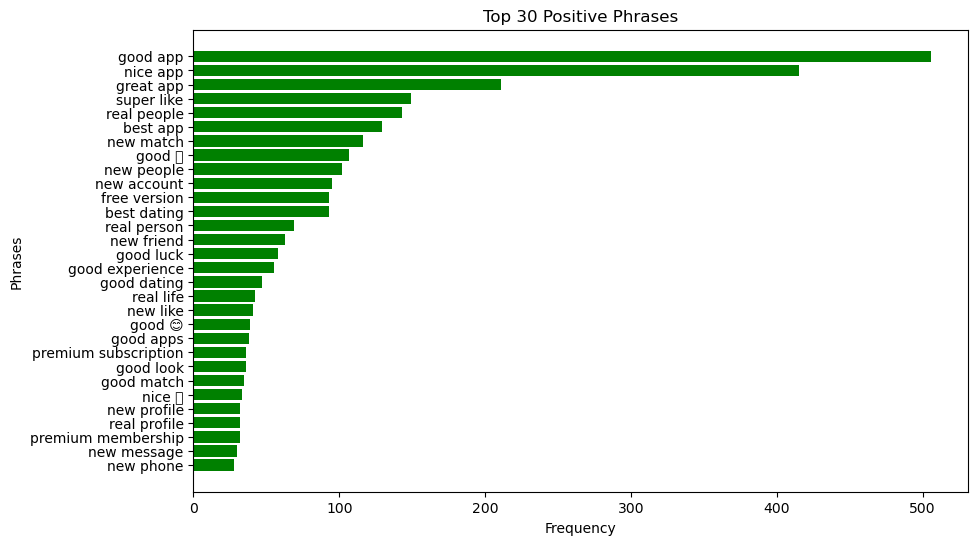

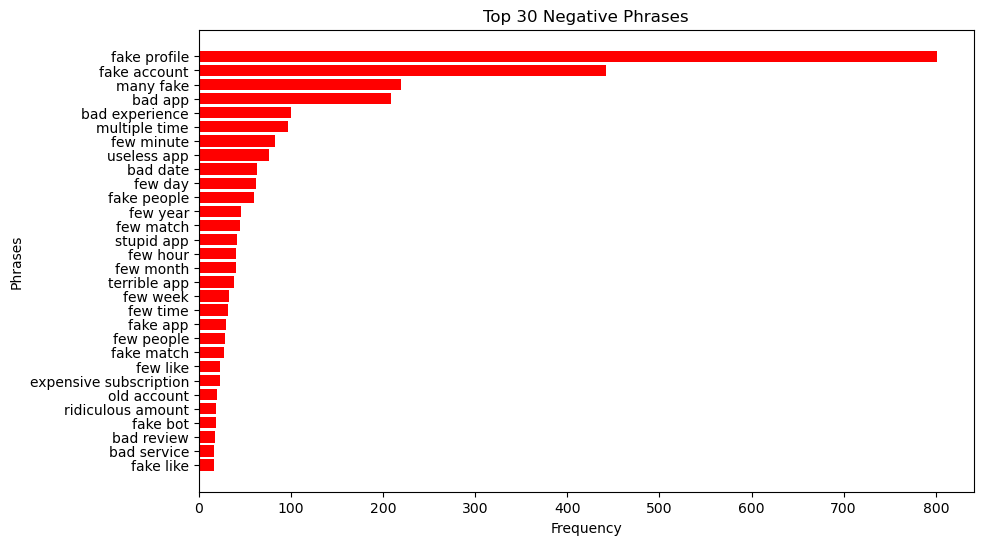

In [53]:
# Convert positive and negative phrases into DataFrames
positive_df = pd.DataFrame(positive_phrases_counts, columns=['Phrase', 'Frequency'])
negative_df = pd.DataFrame(negative_phrases_counts, columns=['Phrase', 'Frequency'])

# Plot positive phrases
plt.figure(figsize=(10, 6))
plt.barh(positive_df['Phrase'], positive_df['Frequency'], color='green')
plt.title('Top 30 Positive Phrases')
plt.xlabel('Frequency')
plt.ylabel('Phrases')
plt.gca().invert_yaxis()  # Invert the y-axis
plt.show()

# Plot negative phrases
plt.figure(figsize=(10, 6))
plt.barh(negative_df['Phrase'], negative_df['Frequency'], color='red')
plt.title('Top 30 Negative Phrases')
plt.xlabel('Frequency')
plt.ylabel('Phrases')
plt.gca().invert_yaxis()
plt.show()


In [55]:
from collections import Counter

# Extract phrases and classify sentiment (using the previously defined phrase extraction function)
data['phrases'] = data['content'].apply(extract_phrases)

# Classify positive and negative phrases
data['Positive_Phrases'] = data['phrases'].apply(
    lambda phrases: [phrase for phrase in phrases if any(word in phrase.split() for word in positive_words)]
)
data['Negative_Phrases'] = data['phrases'].apply(
    lambda phrases: [phrase for phrase in phrases if any(word in phrase.split() for word in negative_words)]
)

# Group phrases by ratings
positive_phrases_by_score = data.groupby('score')['Positive_Phrases'].apply(
    lambda x: Counter([phrase for phrases in x for phrase in phrases]).most_common(10)
)
negative_phrases_by_score = data.groupby('score')['Negative_Phrases'].apply(
    lambda x: Counter([phrase for phrases in x for phrase in phrases]).most_common(10)
)

# Print positive phrases
print("Top 10 Positive Phrases by Score:")
for score, phrases in positive_phrases_by_score.items():
    print(f"Score {score}:")
    for phrase, count in phrases:
        print(f"  {phrase}: {count}")

# Print negative phrases
print("\nTop 10 Negative Phrases by Score:")
for score, phrases in negative_phrases_by_score.items():
    print(f"Score {score}:")
    for phrase, count in phrases:
        print(f"  {phrase}: {count}")



Top 10 Positive Phrases by Score:
Score 1:
  super like: 127
  real people: 116
  new match: 91
  new account: 89
  free version: 71
  good app: 70
  real person: 62
  good luck: 40
  new people: 39
  new like: 39
Score 2:
  good app: 21
  new match: 19
  free version: 15
  real people: 14
  super like: 13
  new message: 10
  nice app: 8
  good luck: 7
  new people: 6
  great app: 6
Score 3:
  good app: 40
  nice app: 33
  great app: 13
  super like: 8
  good 👍: 7
  good 😊: 5
  good platform: 5
  new match: 5
  free version: 5
  free like: 5
Score 4:
  good app: 68
  nice app: 54
  great app: 36
  good 👍: 16
  best app: 13
  new friend: 12
  new people: 12
  best dating: 11
  good 😊: 7
  good dating: 7
Score 5:
  nice app: 308
  good app: 307
  great app: 136
  best app: 103
  good 👍: 81
  best dating: 68
  new friend: 42
  new people: 41
  nice 👍: 26
  good 😊: 24

Top 10 Negative Phrases by Score:
Score 1:
  fake profile: 692
  fake account: 368
  bad app: 193
  many fake: 170
  bad e

# Sentiment Classification
1. Naive Bayes

In [8]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
df = pd.read_csv('tinder_google_play_reviews.csv')
df['at'] = pd.to_datetime(df['at'], errors='coerce')
df = df[df['at'] > '2024-01-01']

# Check column names to ensure the correct columns are being used
print("Columns in dataset:", df.columns)

# Use only the 'content' and 'score' columns and drop rows with missing values
df = df[['content', 'score']].dropna()


# Display the first few rows of the dataset
print("Sample data:\n", df.head())

Columns in dataset: Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion'],
      dtype='object')
Sample data:
                                              content  score
0  This app is 100% a money scam and I didn't eve...      1
1                                      Waste of time      2
2  Straightforward, safety features and super eas...      5
3               I got banned over a meme. Hella lame      1
4  Mandatory facial check.👎🏼 I do not want to giv...      1


In [9]:
# Assign sentiment labels based on the 'score' column
# 1-2 stars = negative, 4-5 stars = positive, 3 stars = neutral
def assign_label(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

df['label'] = df['score'].apply(assign_label)

# Check label distribution
print("Label distribution:\n", df['label'].value_counts())


Label distribution:
 label
negative    30316
positive    14659
neutral      2697
Name: count, dtype: int64


In [10]:
# Split the data into features (X) and labels (y)
X = df['content']
y = df['label']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data to numeric using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=5000)  # Remove common stopwords and limit features
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Initialize the Naive Bayes classifier
clf = MultinomialNB()

# Train the classifier
clf.fit(X_train_counts, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test_counts)

# Evaluate the model’s performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display a detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8321971683272156
Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.92      0.89      6089
     neutral       0.21      0.06      0.10       558
    positive       0.80      0.79      0.80      2888

    accuracy                           0.83      9535
   macro avg       0.62      0.59      0.59      9535
weighted avg       0.81      0.83      0.82      9535



In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Split the data into features (X) and labels (y)
X = df['content']  
y = df['label']

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid (trying different alpha values)
param_grid = {'alpha': np.linspace(0.1, 2.0, 10)}  # Testing alpha from 0.1 to 2.0

# Function to train, tune, and evaluate Naive Bayes with different vectorizers
def evaluate_model(vectorizer, vectorizer_name):
    # Convert text data using the given vectorizer
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Define the Naive Bayes model
    clf = MultinomialNB()

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(clf, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
    grid_search.fit(X_train_vec, y_train)

    # Get the best alpha
    best_alpha = grid_search.best_params_['alpha']
    print(f"\nBest alpha for {vectorizer_name}: {best_alpha}")

    # Train the final model using the best alpha
    best_clf = MultinomialNB(alpha=best_alpha)
    best_clf.fit(X_train_vec, y_train)

    # Make predictions
    y_pred = best_clf.predict(X_test_vec)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Final Model Accuracy with {vectorizer_name}: {accuracy:.4f}")
    print(f"Classification Report for {vectorizer_name}:\n", classification_report(y_test, y_pred))

# Evaluate CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english', max_features=5000)
evaluate_model(count_vectorizer, "CountVectorizer")

# Evaluate TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
evaluate_model(tfidf_vectorizer, "TF-IDF")



Best alpha for CountVectorizer: 0.1
Final Model Accuracy with CountVectorizer: 0.8336
Classification Report for CountVectorizer:
               precision    recall  f1-score   support

    negative       0.86      0.92      0.89      6089
     neutral       0.24      0.09      0.13       558
    positive       0.81      0.79      0.80      2888

    accuracy                           0.83      9535
   macro avg       0.64      0.60      0.61      9535
weighted avg       0.81      0.83      0.82      9535


Best alpha for TF-IDF: 0.1
Final Model Accuracy with TF-IDF: 0.8429
Classification Report for TF-IDF:
               precision    recall  f1-score   support

    negative       0.84      0.96      0.90      6089
     neutral       0.00      0.00      0.00       558
    positive       0.85      0.75      0.80      2888

    accuracy                           0.84      9535
   macro avg       0.56      0.57      0.57      9535
weighted avg       0.80      0.84      0.82      9535



2. K-Nearest Neighbors

In [5]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter


# Load the Tinder reviews dataset
df = pd.read_csv('tinder_google_play_reviews.csv')
df['at'] = pd.to_datetime(df['at'], errors='coerce')
df = df[df['at'] > '2024-01-01']

# Use only the 'content' (review text) and 'score' (rating) columns and drop rows with missing values
df = df[['content', 'score']].dropna()

# Rename columns for clarity
df.rename(columns={'content': 'Message', 'score': 'Rating'}, inplace=True)

# Display the first few rows to verify the dataset
print(df.head())

# Assign sentiment labels based on the rating
def assign_label(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['Label'] = df['Rating'].apply(assign_label)

# Check label distribution
print("Label distribution:\n", df['Label'].value_counts())


                                             Message  Rating
0  This app is 100% a money scam and I didn't eve...       1
1                                      Waste of time       2
2  Straightforward, safety features and super eas...       5
3               I got banned over a meme. Hella lame       1
4  Mandatory facial check.👎🏼 I do not want to giv...       1
Label distribution:
 Label
negative    30316
positive    14659
neutral      2697
Name: count, dtype: int64


In [6]:
# Split the data into features (X) and labels (y)
X = df['Message']
y = df['Label']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data to TF-IDF representation
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Reset the indices of y_train to align with X_train_tfidf
y_train = y_train.reset_index(drop=True)

# Define a function to classify messages using KNN
def classify_message(test_vec, train_vecs, train_labels, k=3):
    # Compute cosine similarity between the test vector and all training vectors
    similarities = cosine_similarity(test_vec, train_vecs).flatten()
    
    # Get indices of the top k most similar messages
    top_k_indices = similarities.argsort()[-k:][::-1]
    
    # Get the labels of the k nearest neighbors
    top_k_labels = [train_labels[i] for i in top_k_indices]
    
    # Return the majority label among the k nearest neighbors
    return Counter(top_k_labels).most_common(1)[0][0]

# Make predictions on the test set
y_pred = []
for i in range(X_test_tfidf.shape[0]):
    pred_label = classify_message(X_test_tfidf[i], X_train_tfidf, y_train, k=3)
    y_pred.append(pred_label)


# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display a detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7920293654955427
Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.86      0.86      6089
     neutral       0.11      0.04      0.06       558
    positive       0.71      0.79      0.75      2888

    accuracy                           0.79      9535
   macro avg       0.56      0.56      0.55      9535
weighted avg       0.77      0.79      0.78      9535



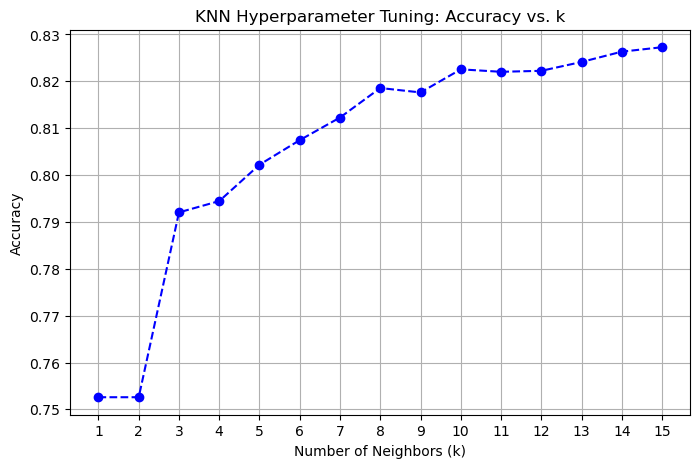

Best k: 15 with Accuracy: 0.8273

Final Model Evaluation
Best k: 15
Accuracy: 0.8272679601468275
Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.92      0.89      6089
     neutral       0.33      0.03      0.05       558
    positive       0.77      0.79      0.78      2888

    accuracy                           0.83      9535
   macro avg       0.65      0.58      0.57      9535
weighted avg       0.80      0.83      0.81      9535



In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

# Compute cosine similarity for all test samples at once
similarities = cosine_similarity(X_test_tfidf, X_train_tfidf)

# Function to predict label based on KNN with cosine similarity
def knn_predict(sim_matrix, train_labels, k):
    predictions = []
    for sim_row in sim_matrix:
        # Get indices of top k most similar messages
        top_k_indices = sim_row.argsort()[-k:][::-1]
        
        # Get corresponding labels
        top_k_labels = train_labels[top_k_indices]
        
        # Determine majority label
        most_common_label = Counter(top_k_labels).most_common(1)[0][0]
        predictions.append(most_common_label)
    
    return predictions

# Tune KNN hyperparameter (finding the best k)
k_values = range(1, 16)  # Try k from 1 to 15
accuracy_scores = []

for k in k_values:
    y_pred = knn_predict(similarities, y_train, k)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Plot accuracy vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='dashed', color='b')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN Hyperparameter Tuning: Accuracy vs. k")
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Choose the best k
best_k = k_values[np.argmax(accuracy_scores)]
print(f"Best k: {best_k} with Accuracy: {max(accuracy_scores):.4f}")

# Train final model using best k
y_pred_best = knn_predict(similarities, y_train, best_k)

# Evaluate final model
print("\nFinal Model Evaluation")
print(f"Best k: {best_k}")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))


# Topic Modeling Using LDA

In [71]:
df = pd.read_csv('tinder_google_play_reviews.csv')
df['at'] = pd.to_datetime(df['at'], errors='coerce')
df = df[df['at'] > '2024-01-01']
df['Review'] = df['content']
df.dropna(subset=['Review'], inplace=True)

In [72]:
# Preprocessing
def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)  # Retain only letters
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['cleaned_review'] = df['Review'].apply(preprocess_text)

# Feature extraction
custom_stop_words = list(set(stopwords.words('english')).union({'app', 'tinder', 'version', 'use', 'get', 'even', 'like','de','far','que','la'}))
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=custom_stop_words)
term_matrix = vectorizer.fit_transform(df['cleaned_review'])

# Topic modeling
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(term_matrix)

# Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda_model, feature_names, no_top_words)

Topic 1:
good fake profiles many accounts bots best bad scammers full
Topic 2:
pay nice money time waste love free better everything much
Topic 3:
account delete subscription still profile please working tried verify support
Topic 4:
people matches likes match see money great profiles pay one
Topic 5:
banned reason got account worst dating never without ever ban


In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=3, stop_words=custom_stop_words)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_review'])

lda_model = LatentDirichletAllocation(n_components=6, random_state=42)
lda_model.fit(tfidf_matrix)

display_topics(lda_model, tfidf_vectorizer.get_feature_names_out(), no_top_words=10)


Topic 1:
good best worst dating waste ever time money apps working
Topic 2:
nice ok perfect application site really aap friends lovely wonderful
Topic 3:
pay matches people likes match see cool money awesome time
Topic 4:
account verify verification super working trash review open wow login
Topic 5:
great banned account love reason got delete excellent amazing support
Topic 6:
fake profiles bad many bots expensive scam accounts money full
